### COVID-19 Cases and Deaths
(correct as 0f 12-Mar-2022)

In [440]:
# import os
# import time
# import datetime
# import json
# import sys
import numpy as np         
import pandas as pd        
import matplotlib.pyplot as plt 
from matplotlib import rcParams  
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
import sqlalchemy      

# Visual setup
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# plt.style.use('tableau-colorblind10')   # alternatives below
# plt.style.use('seaborn-colorblind')
plt.style.use('fivethirtyeight')
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
%config InlineBackend.figure_format = 'retina'

# pip install ipython-sql

In [441]:
engine = sqlalchemy.create_engine('mssql+pyodbc://nizam:''@sql/')

### Number of Deaths by COVID-19 Globally

In [442]:
globaldeaths = '''

SELECT sum(new_cases) as TotalCases, sum(cast(new_deaths as int)) as TotalDeaths
FROM PortfolioProject..COVIDDeaths$
Where continent is not null
Order By 1


'''

df_global_death = pd.read_sql_query(globaldeaths,engine)
df_global_death = df_global_death.fillna(value=np.nan)
df_global_death

,TotalCases,TotalDeaths
0,455631442.0,6015550


In [443]:
df_global_death['Recovered'] = df_global_death['TotalCases']-df_global_death['TotalDeaths']
df_global_death.rename(columns={'TotalDeaths':'Deaths'}, inplace=True)
df_global_death.drop(['TotalCases'], axis=1, inplace=True)

In [444]:
df_global_death = df_global_death.transpose()

In [445]:
df_global_death.columns = ['Case Count']
df_global_death = df_global_death.sort_values('Case Count', ascending=False)

In [446]:
label = df_global_death.index.to_list()

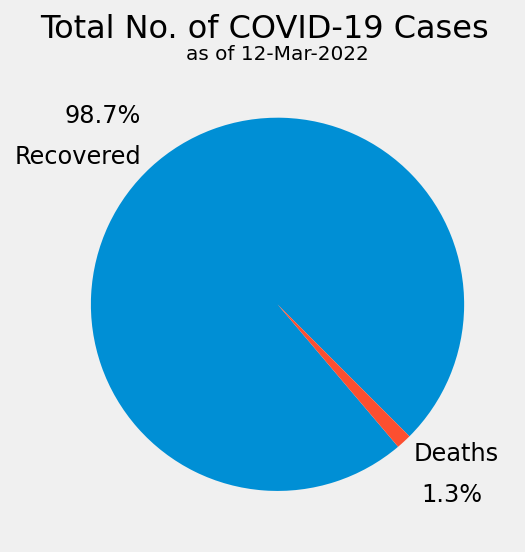

In [447]:
label = df_global_death.index.to_list()
plt.pie(x=df_global_death['Case Count'], labels=label, autopct='%1.1f%%', startangle=-45, textprops={'fontsize': 12}, 
    pctdistance=1.38, labeldistance=1.08)
plt.suptitle('Total No. of COVID-19 Cases', fontsize=16)
plt.title('as of 12-Mar-2022', fontsize=10)
plt.show()

In [448]:
globaldeathquery = '''

SELECT date, sum(new_cases) as TotalCases, sum(cast(new_deaths as int)) as TotalDeaths, 
  sum(cast(new_deaths as int))/sum(new_cases)*100 as DeathPercentage
FROM PortfolioProject..COVIDDeaths$
Where continent is not null
group by date
Order By 1


'''

df_global_death_percent = pd.read_sql_query(globaldeathquery,engine)
df_global_death_percent = df_global_death_percent.fillna(value=np.nan)
df_global_death_percent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 802 entries, 0 to 801
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             802 non-null    object 
 1   TotalCases       780 non-null    float64
 2   TotalDeaths      780 non-null    float64
 3   DeathPercentage  780 non-null    float64
dtypes: float64(3), object(1)
memory usage: 25.2+ KB


In [449]:
df_global_death_percent['date'] = pd.to_datetime(df_global_death_percent['date'])
df_global_death_percent[['TotalCases','TotalDeaths']] = df_global_death_percent[['TotalCases','TotalDeaths']].astype('Int64')

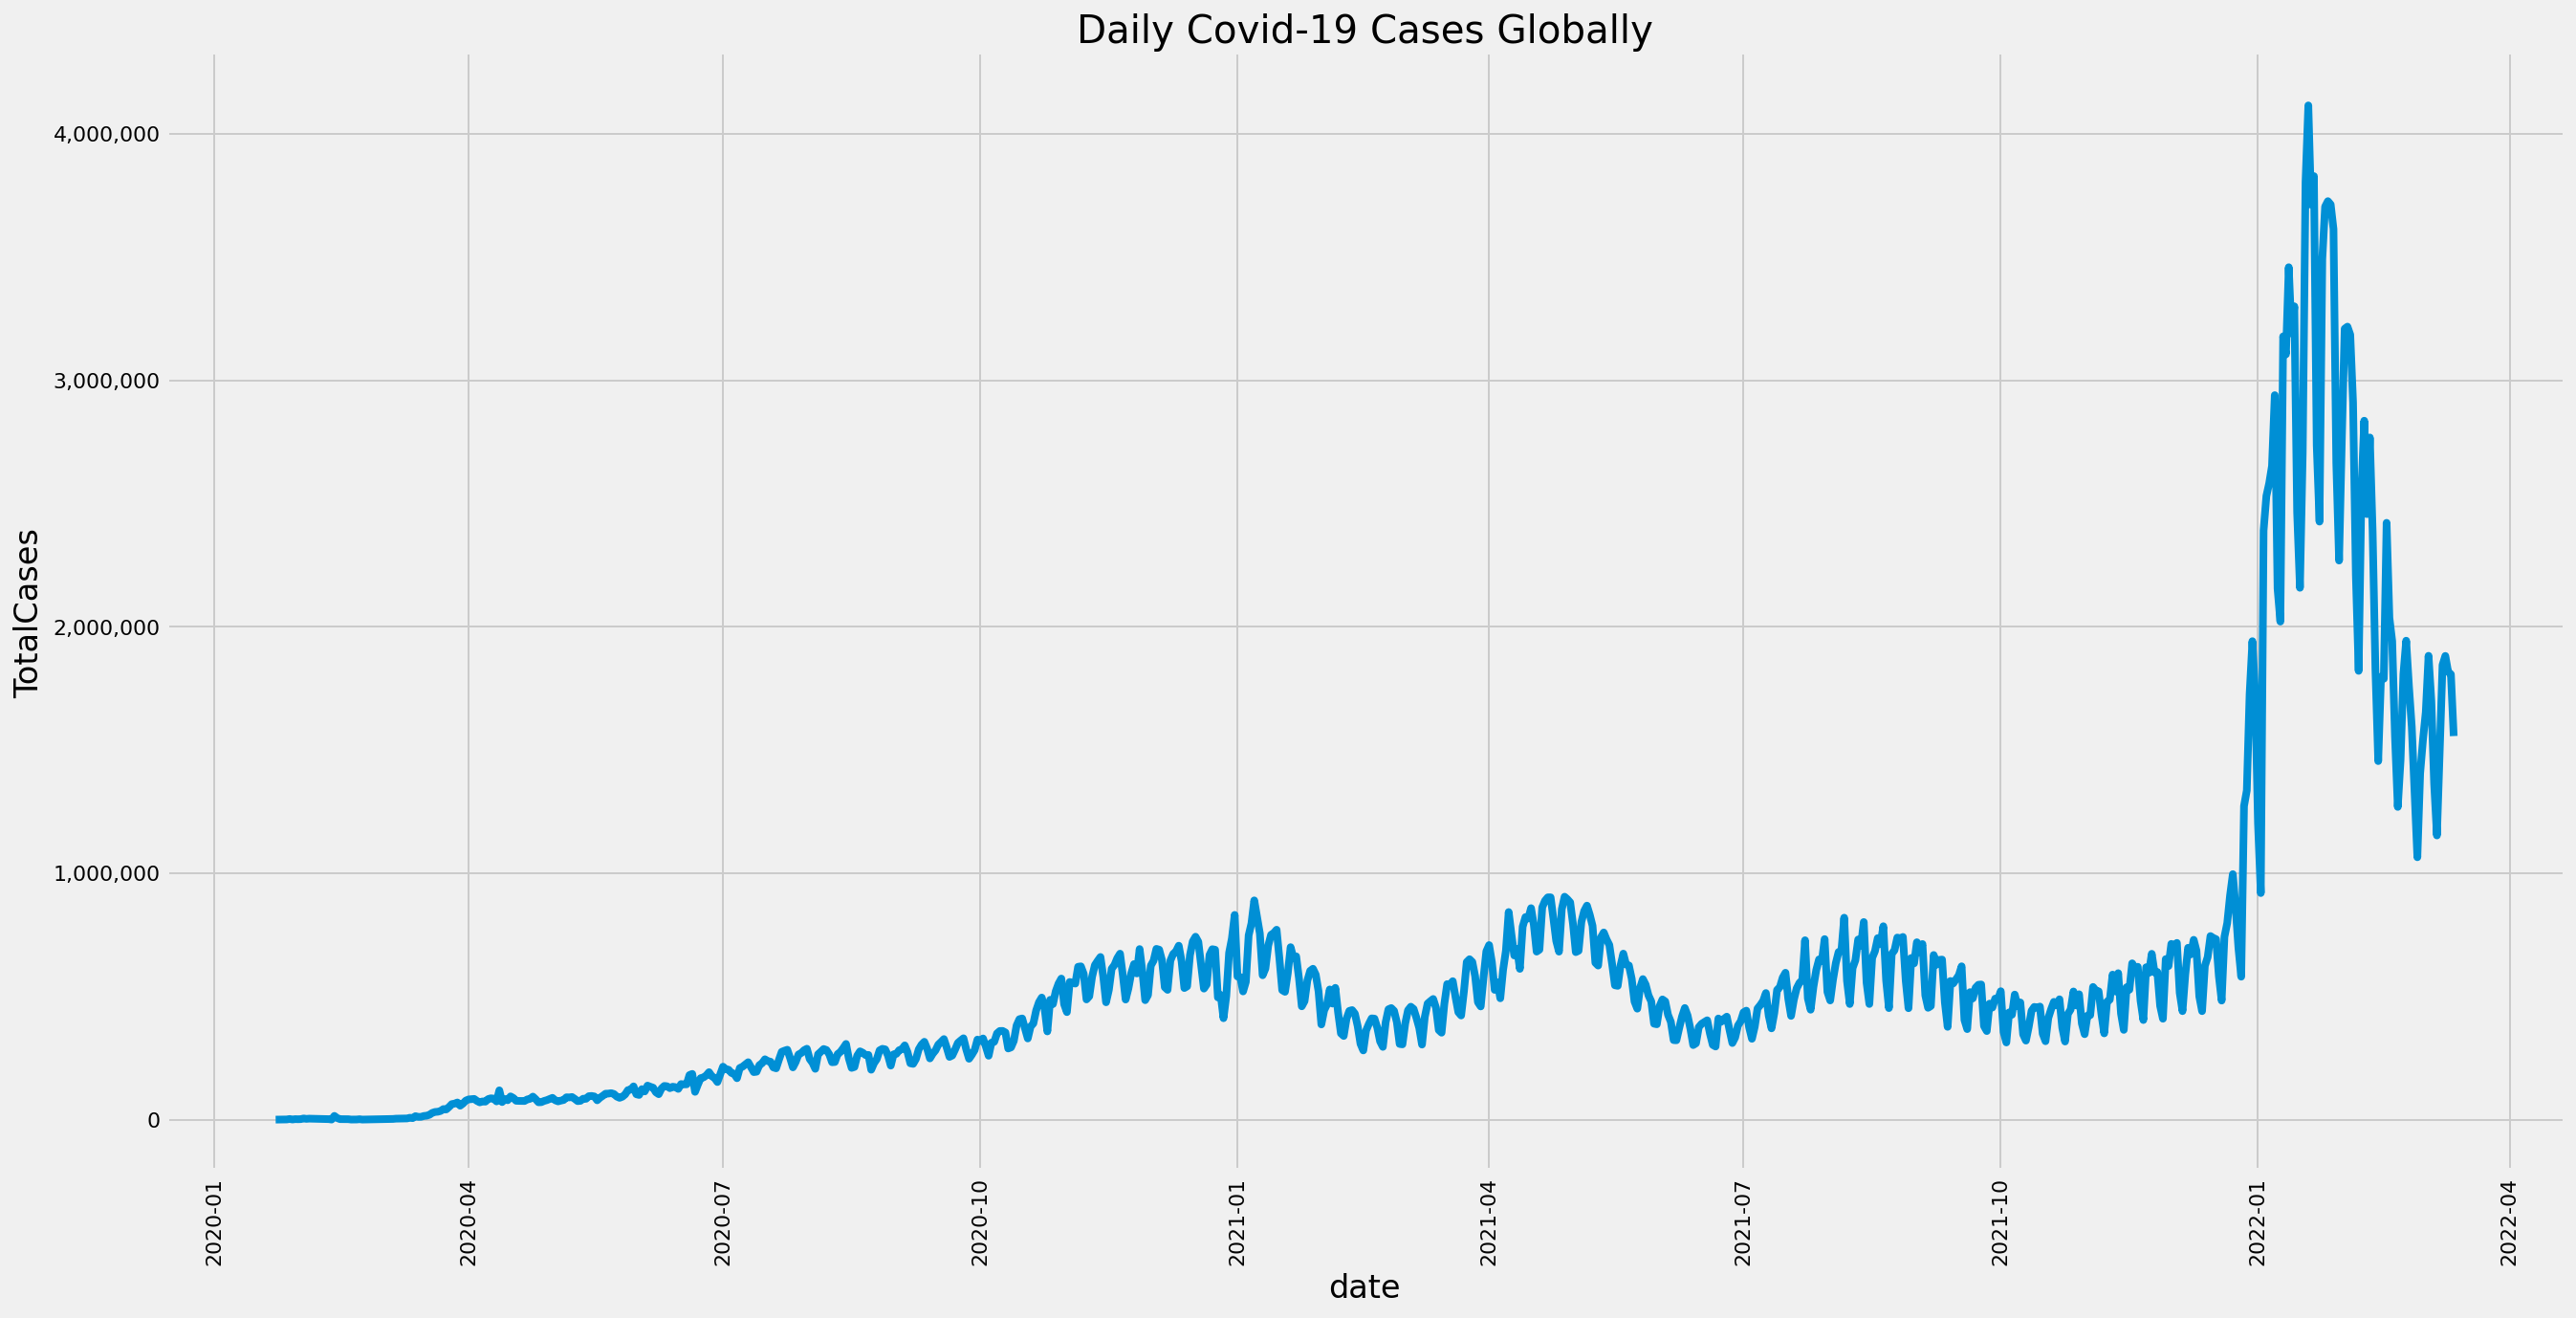

In [450]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(data=df_global_death_percent, x='date', y='TotalCases')
plt.title('Daily Covid-19 Cases Globally')
plt.xticks(rotation=90)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.show()

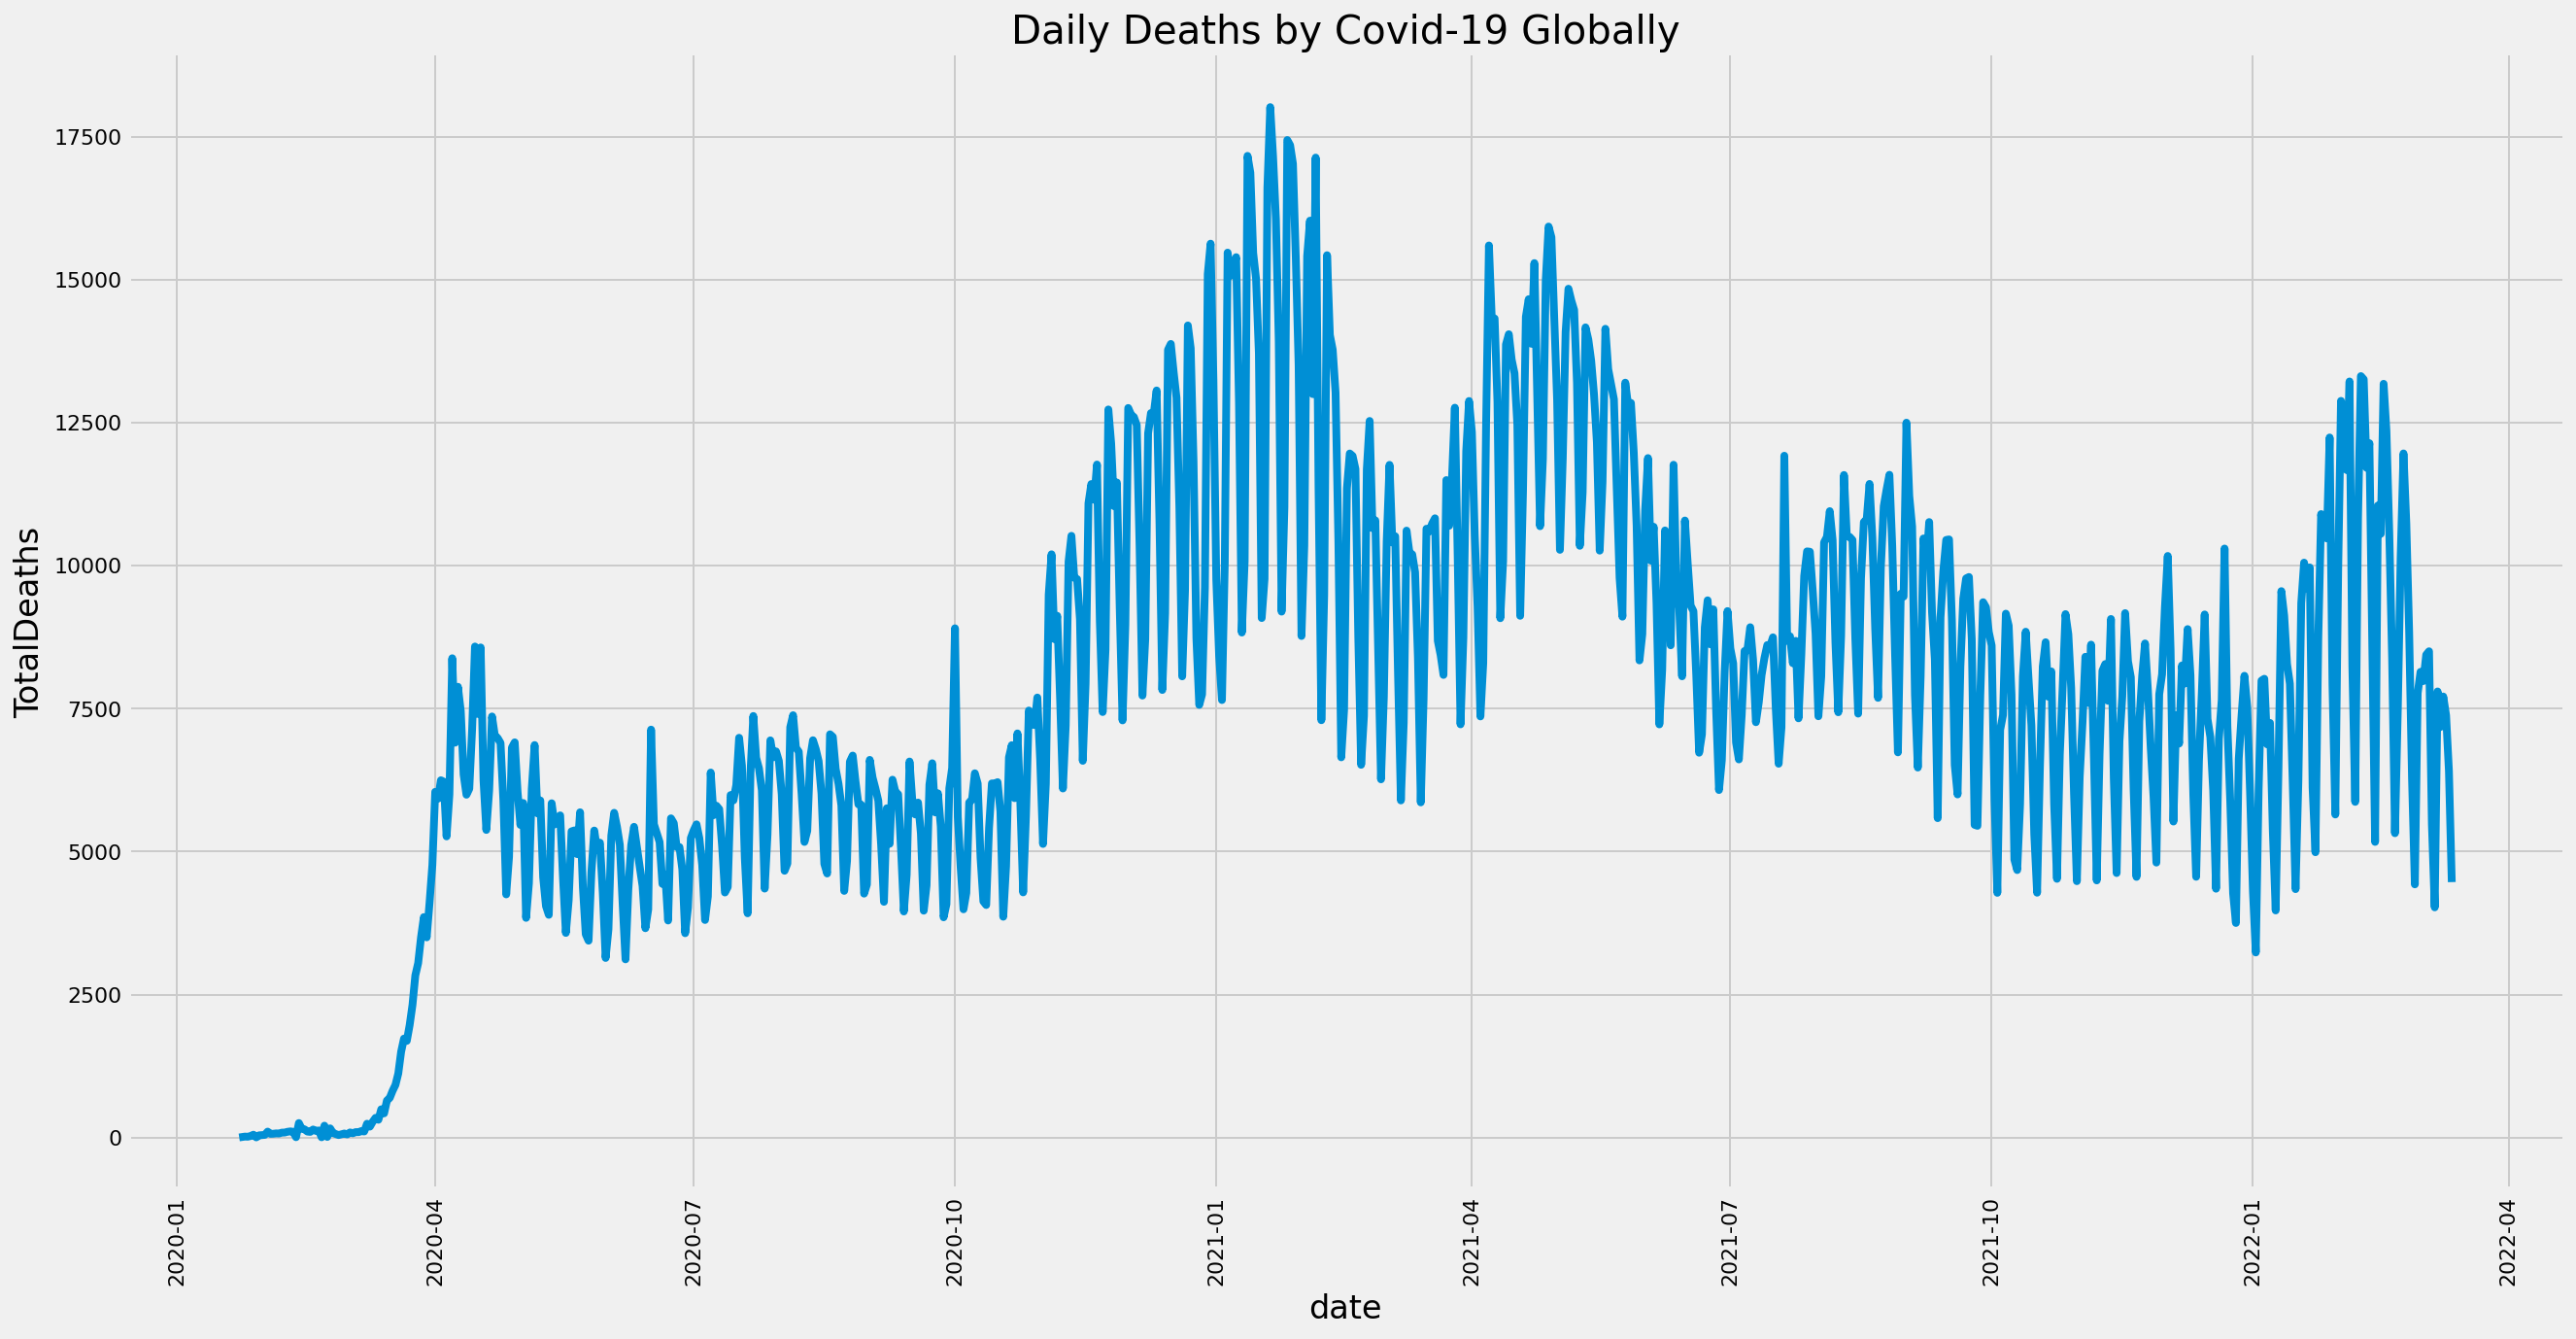

In [451]:
plt.figure(figsize=(20,10))
sns.lineplot(data=df_global_death_percent, x='date', y='TotalDeaths')
plt.title('Daily Deaths by Covid-19 Globally')
plt.xticks(rotation=90)
plt.show()

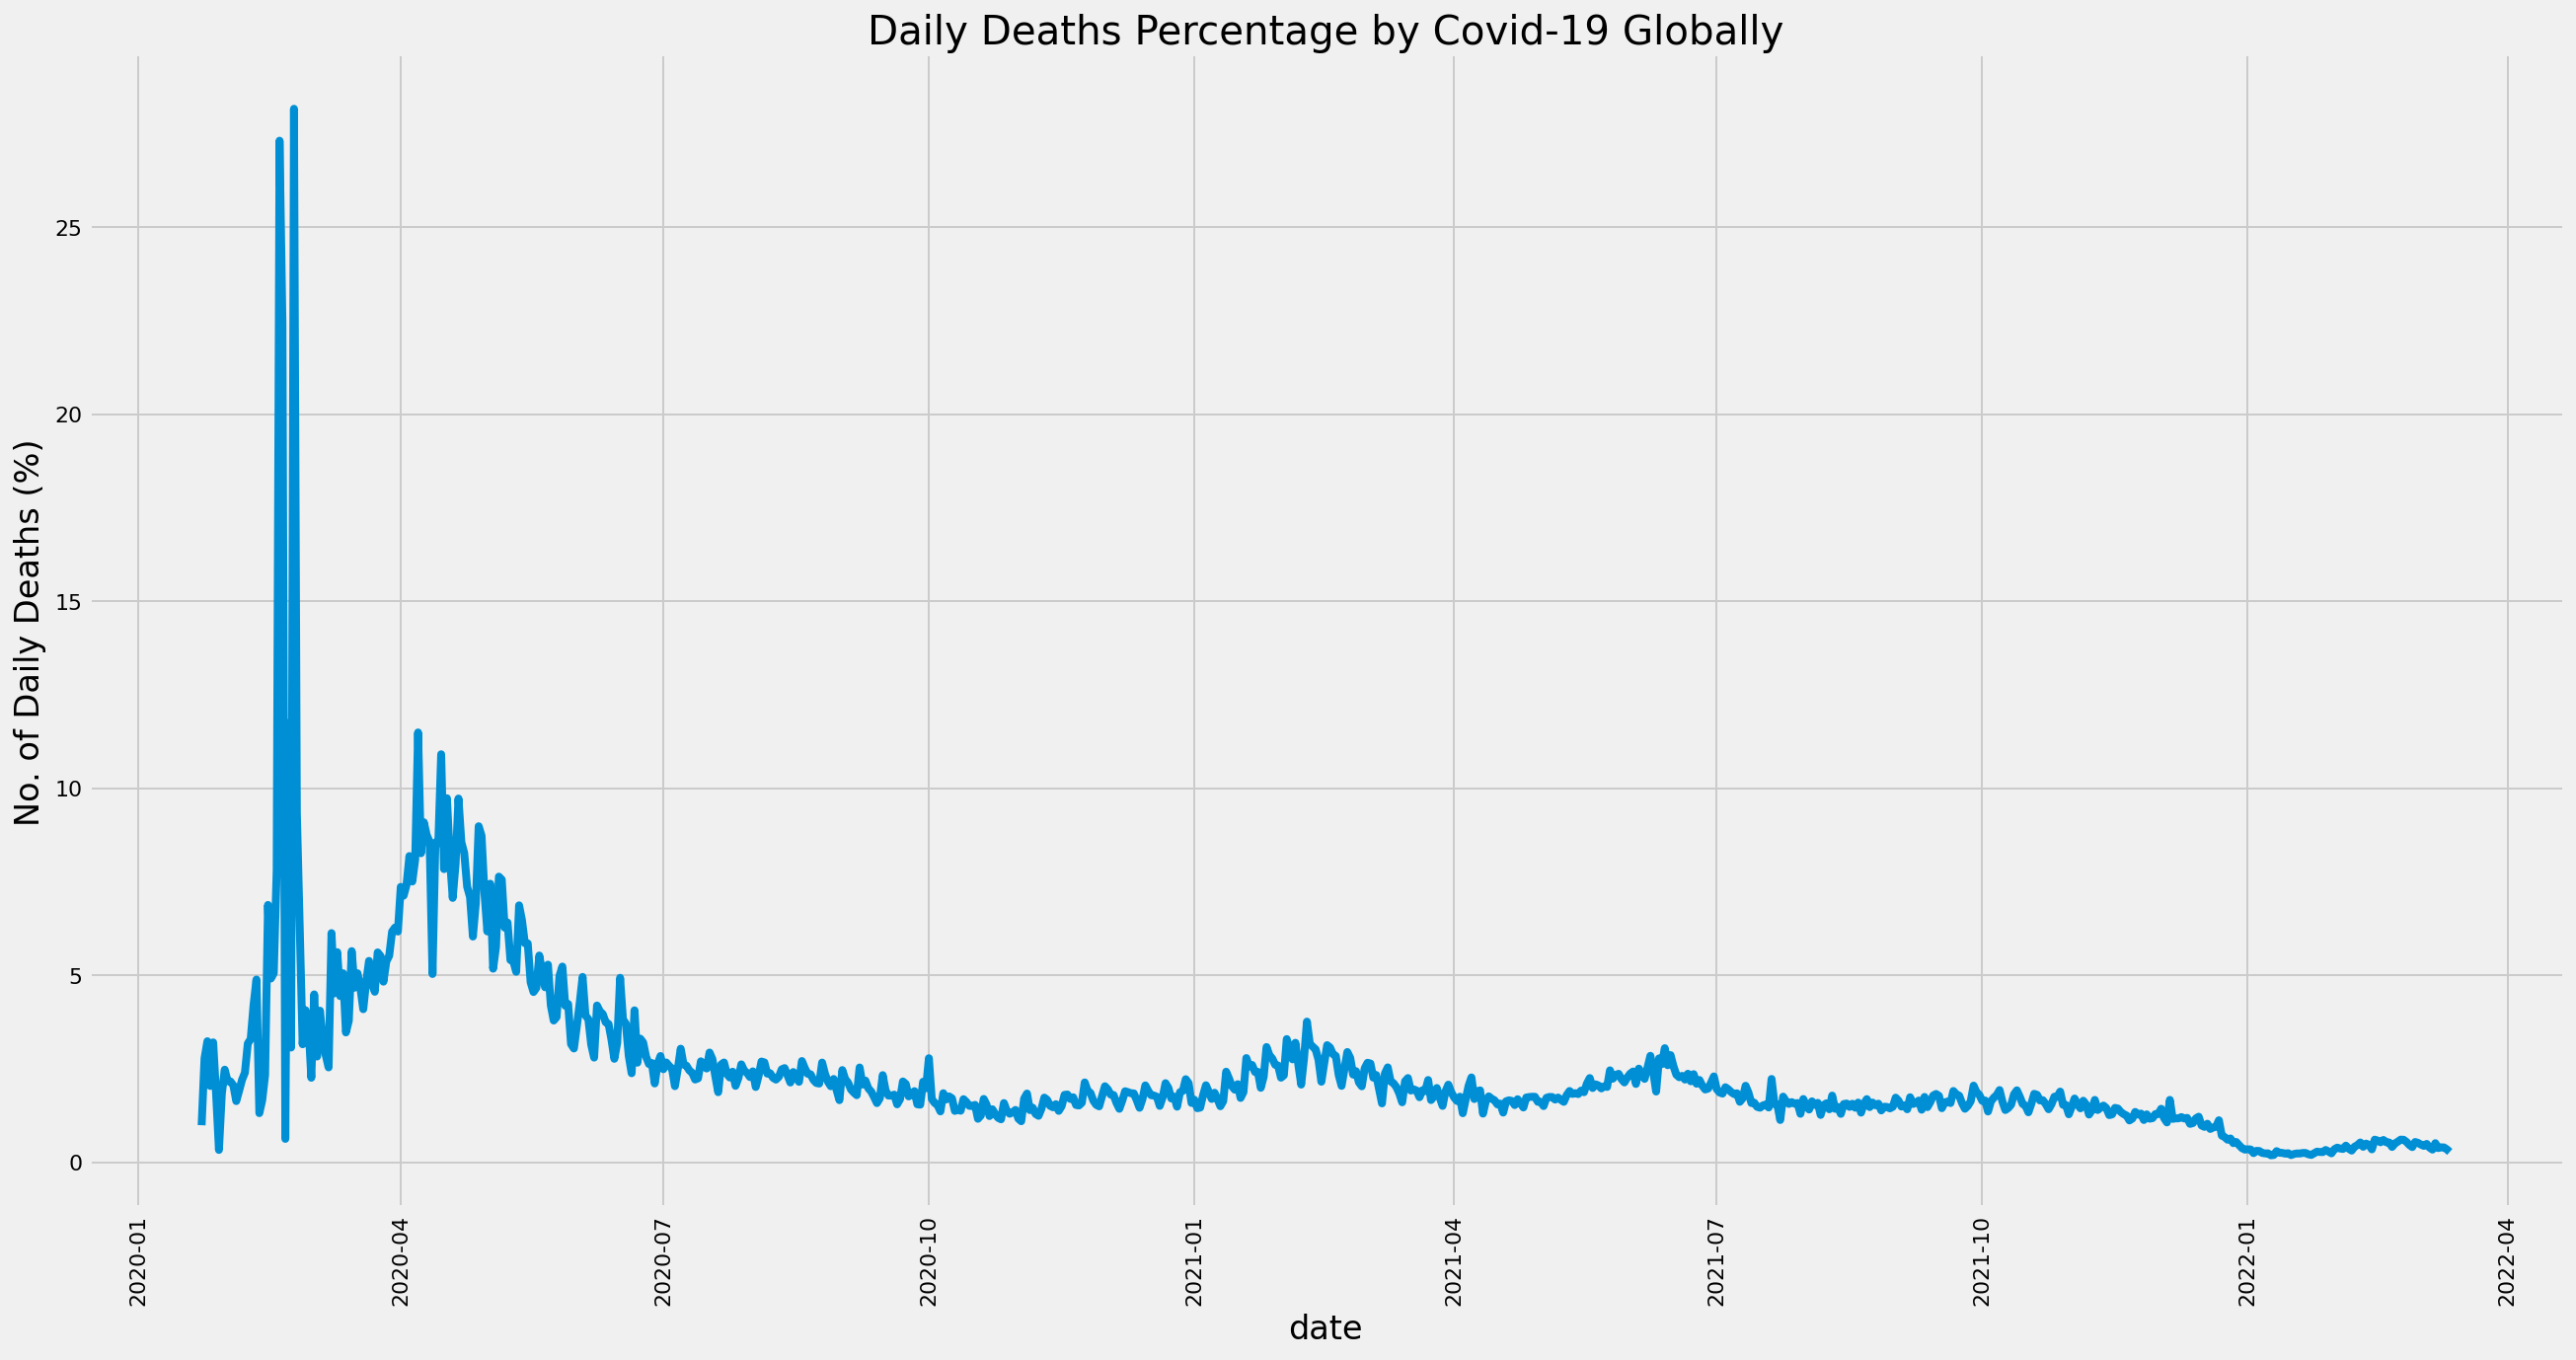

In [452]:
plt.figure(figsize=(20,10))
sns.lineplot(data=df_global_death_percent, x='date', y='DeathPercentage')
plt.title('Daily Deaths Percentage by Covid-19 Globally')
plt.xticks(rotation=90)
plt.ylabel('No. of Daily Deaths (%)')
plt.show()

### Countries with Highest Infection Rates

In [453]:
ratesquery = '''

SELECT location, population, max(total_cases) as HighestInfectionCount, max((total_cases/population))*100 as CasesPercentage
FROM PortfolioProject..COVIDDeaths$
WHERE continent is not null
group by location, population
Order By CasesPercentage desc

'''

df_ratesquery = pd.read_sql_query(ratesquery,engine)
df_ratesquery = df_ratesquery.fillna(value=np.nan)
df_ratesquery.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   location               225 non-null    object 
 1   population             224 non-null    float64
 2   HighestInfectionCount  215 non-null    float64
 3   CasesPercentage        215 non-null    float64
dtypes: float64(3), object(1)
memory usage: 7.2+ KB


In [454]:
df_ratesquery = df_ratesquery.sort_values('CasesPercentage', ascending=False).head(10)

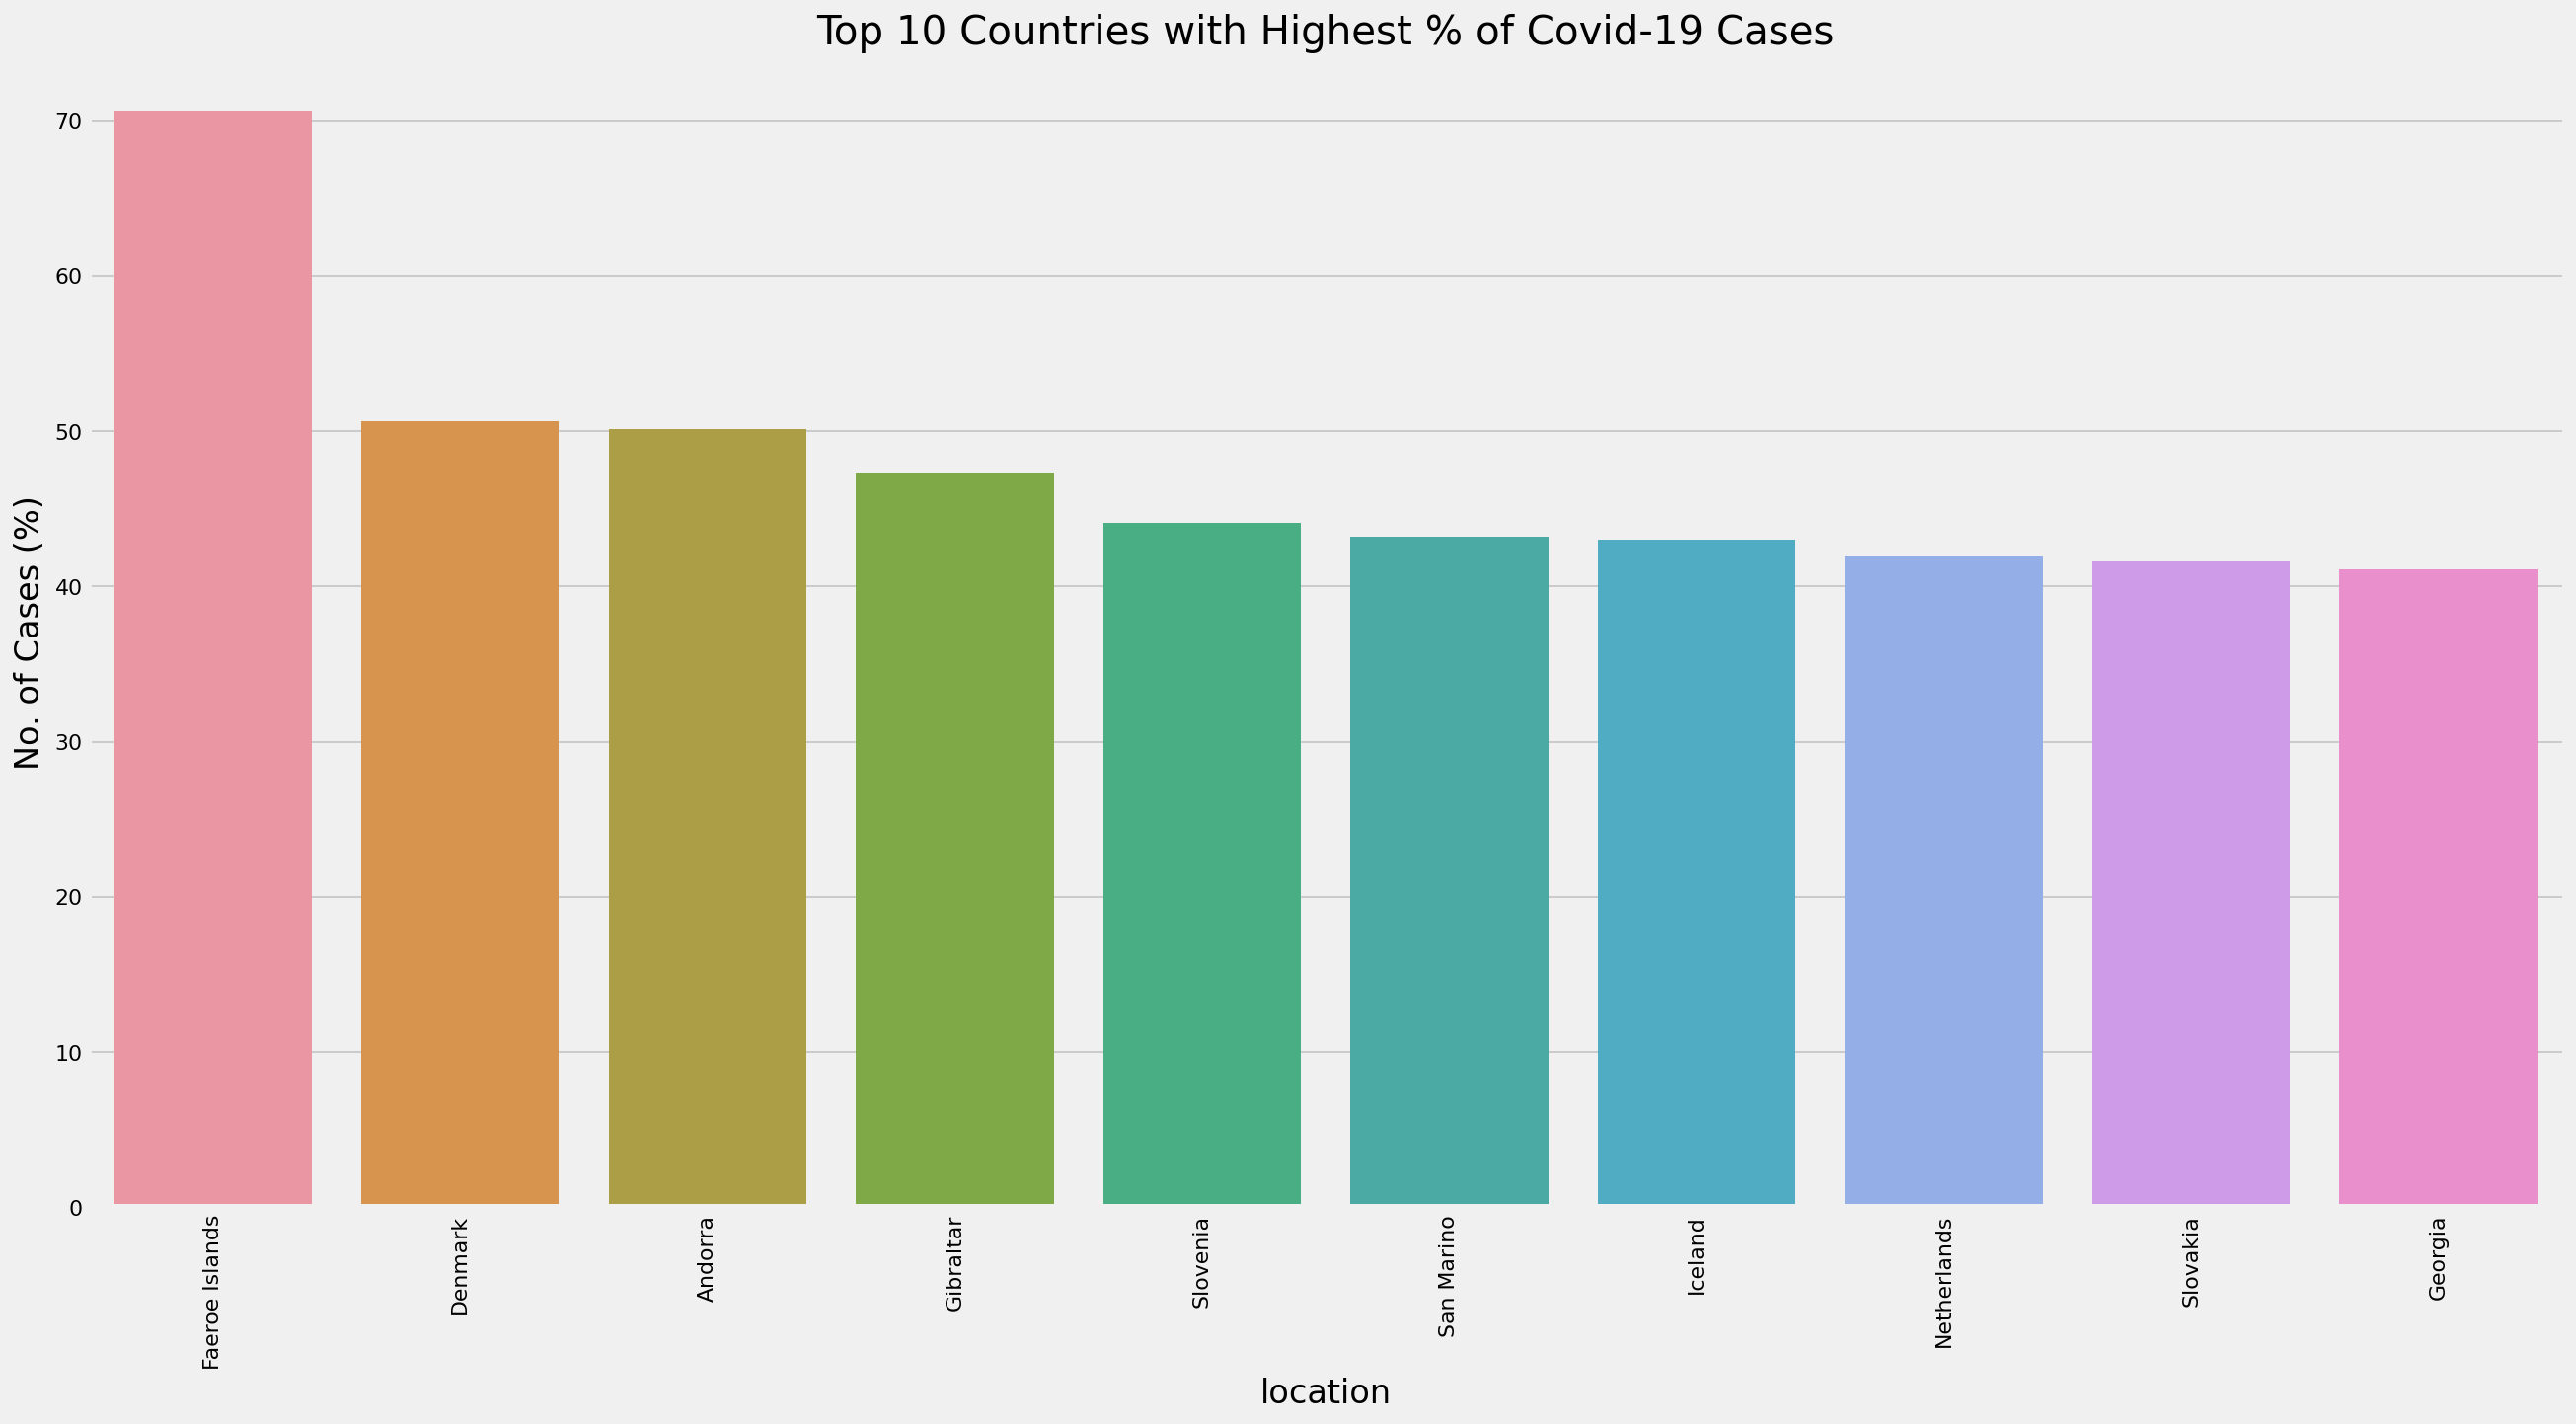

In [455]:
plt.figure(figsize=(20,10))
sns.barplot(data=df_ratesquery,x='location',y='CasesPercentage')
plt.title('Top 10 Countries with Highest % of Covid-19 Cases')
plt.ylabel('No. of Cases (%)')
plt.xticks(rotation=90)
plt.show()

### Countries with Highest Death Count per Population

In [456]:
deathsbycountry = '''

SELECT location, max(cast(total_deaths as int)) as TotalDeathCount
FROM PortfolioProject..COVIDDeaths$
WHERE continent is not null
group by location
Order By TotalDeathCount desc

'''

df_countrydeaths = pd.read_sql_query(deathsbycountry,engine)
df_countrydeaths = df_countrydeaths.fillna(value=np.nan)
df_countrydeaths.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   location         225 non-null    object 
 1   TotalDeathCount  207 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.6+ KB


In [457]:
df_10countrydeaths = df_countrydeaths.sort_values(by='TotalDeathCount', ascending=False).head(10)

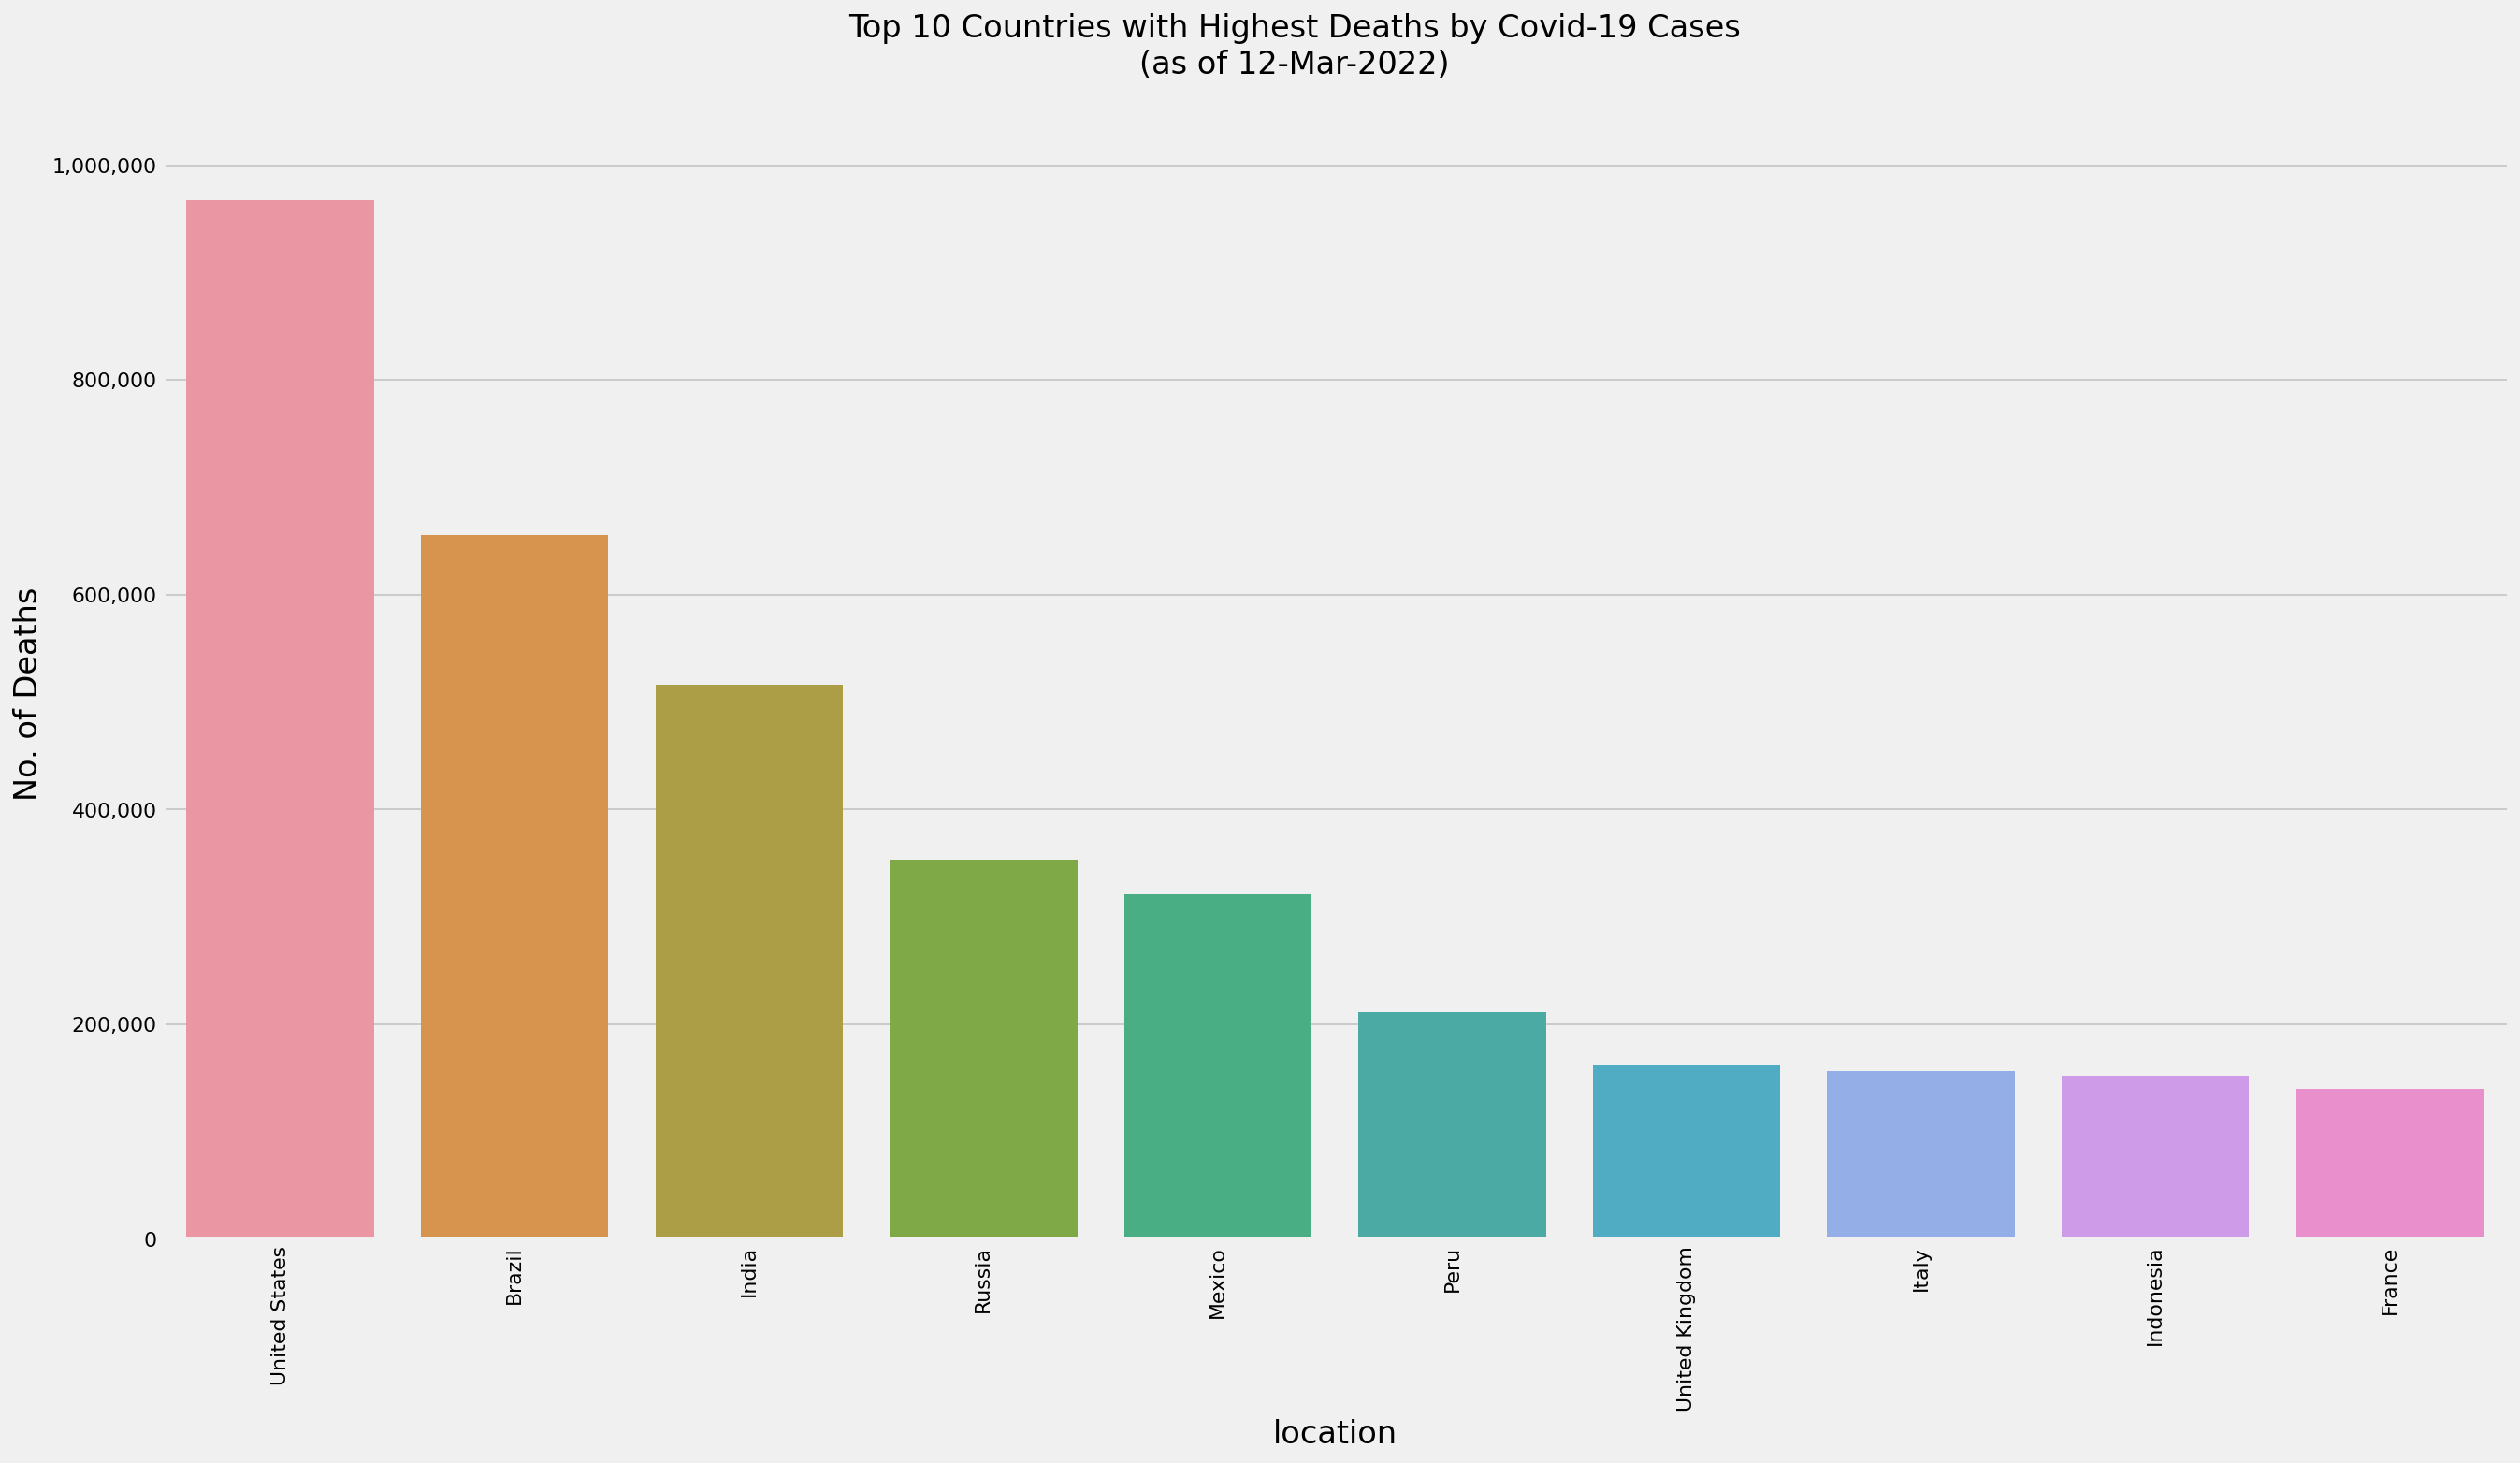

In [458]:
plt.figure(figsize=(20,10))
ax = sns.barplot(data=df_10countrydeaths,x='location',y='TotalDeathCount')
plt.suptitle('Top 10 Countries with Highest Deaths by Covid-19 Cases\n(as of 12-Mar-2022)')
plt.ylabel('No. of Deaths')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.xticks(rotation=90)
plt.show()

### Percentage of deaths by COVID-19 in Singapore

In [459]:
deathquery = '''

SELECT location, date, total_cases, total_deaths, (total_deaths/total_cases)*100 as DeathPercentage
FROM PortfolioProject..COVIDDeaths$
Where location = 'Singapore'
Order By 1, 2

'''

df_death_percent = pd.read_sql_query(deathquery,engine)
df_death_percent = df_death_percent.fillna(value=np.nan)
df_death_percent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   location         780 non-null    object 
 1   date             780 non-null    object 
 2   total_cases      780 non-null    float64
 3   total_deaths     722 non-null    object 
 4   DeathPercentage  722 non-null    float64
dtypes: float64(2), object(3)
memory usage: 30.6+ KB


In [460]:
df_death_percent['date'] = pd.to_datetime(df_death_percent['date'])
df_death_percent['total_deaths'] = pd.to_numeric(df_death_percent['total_deaths'])

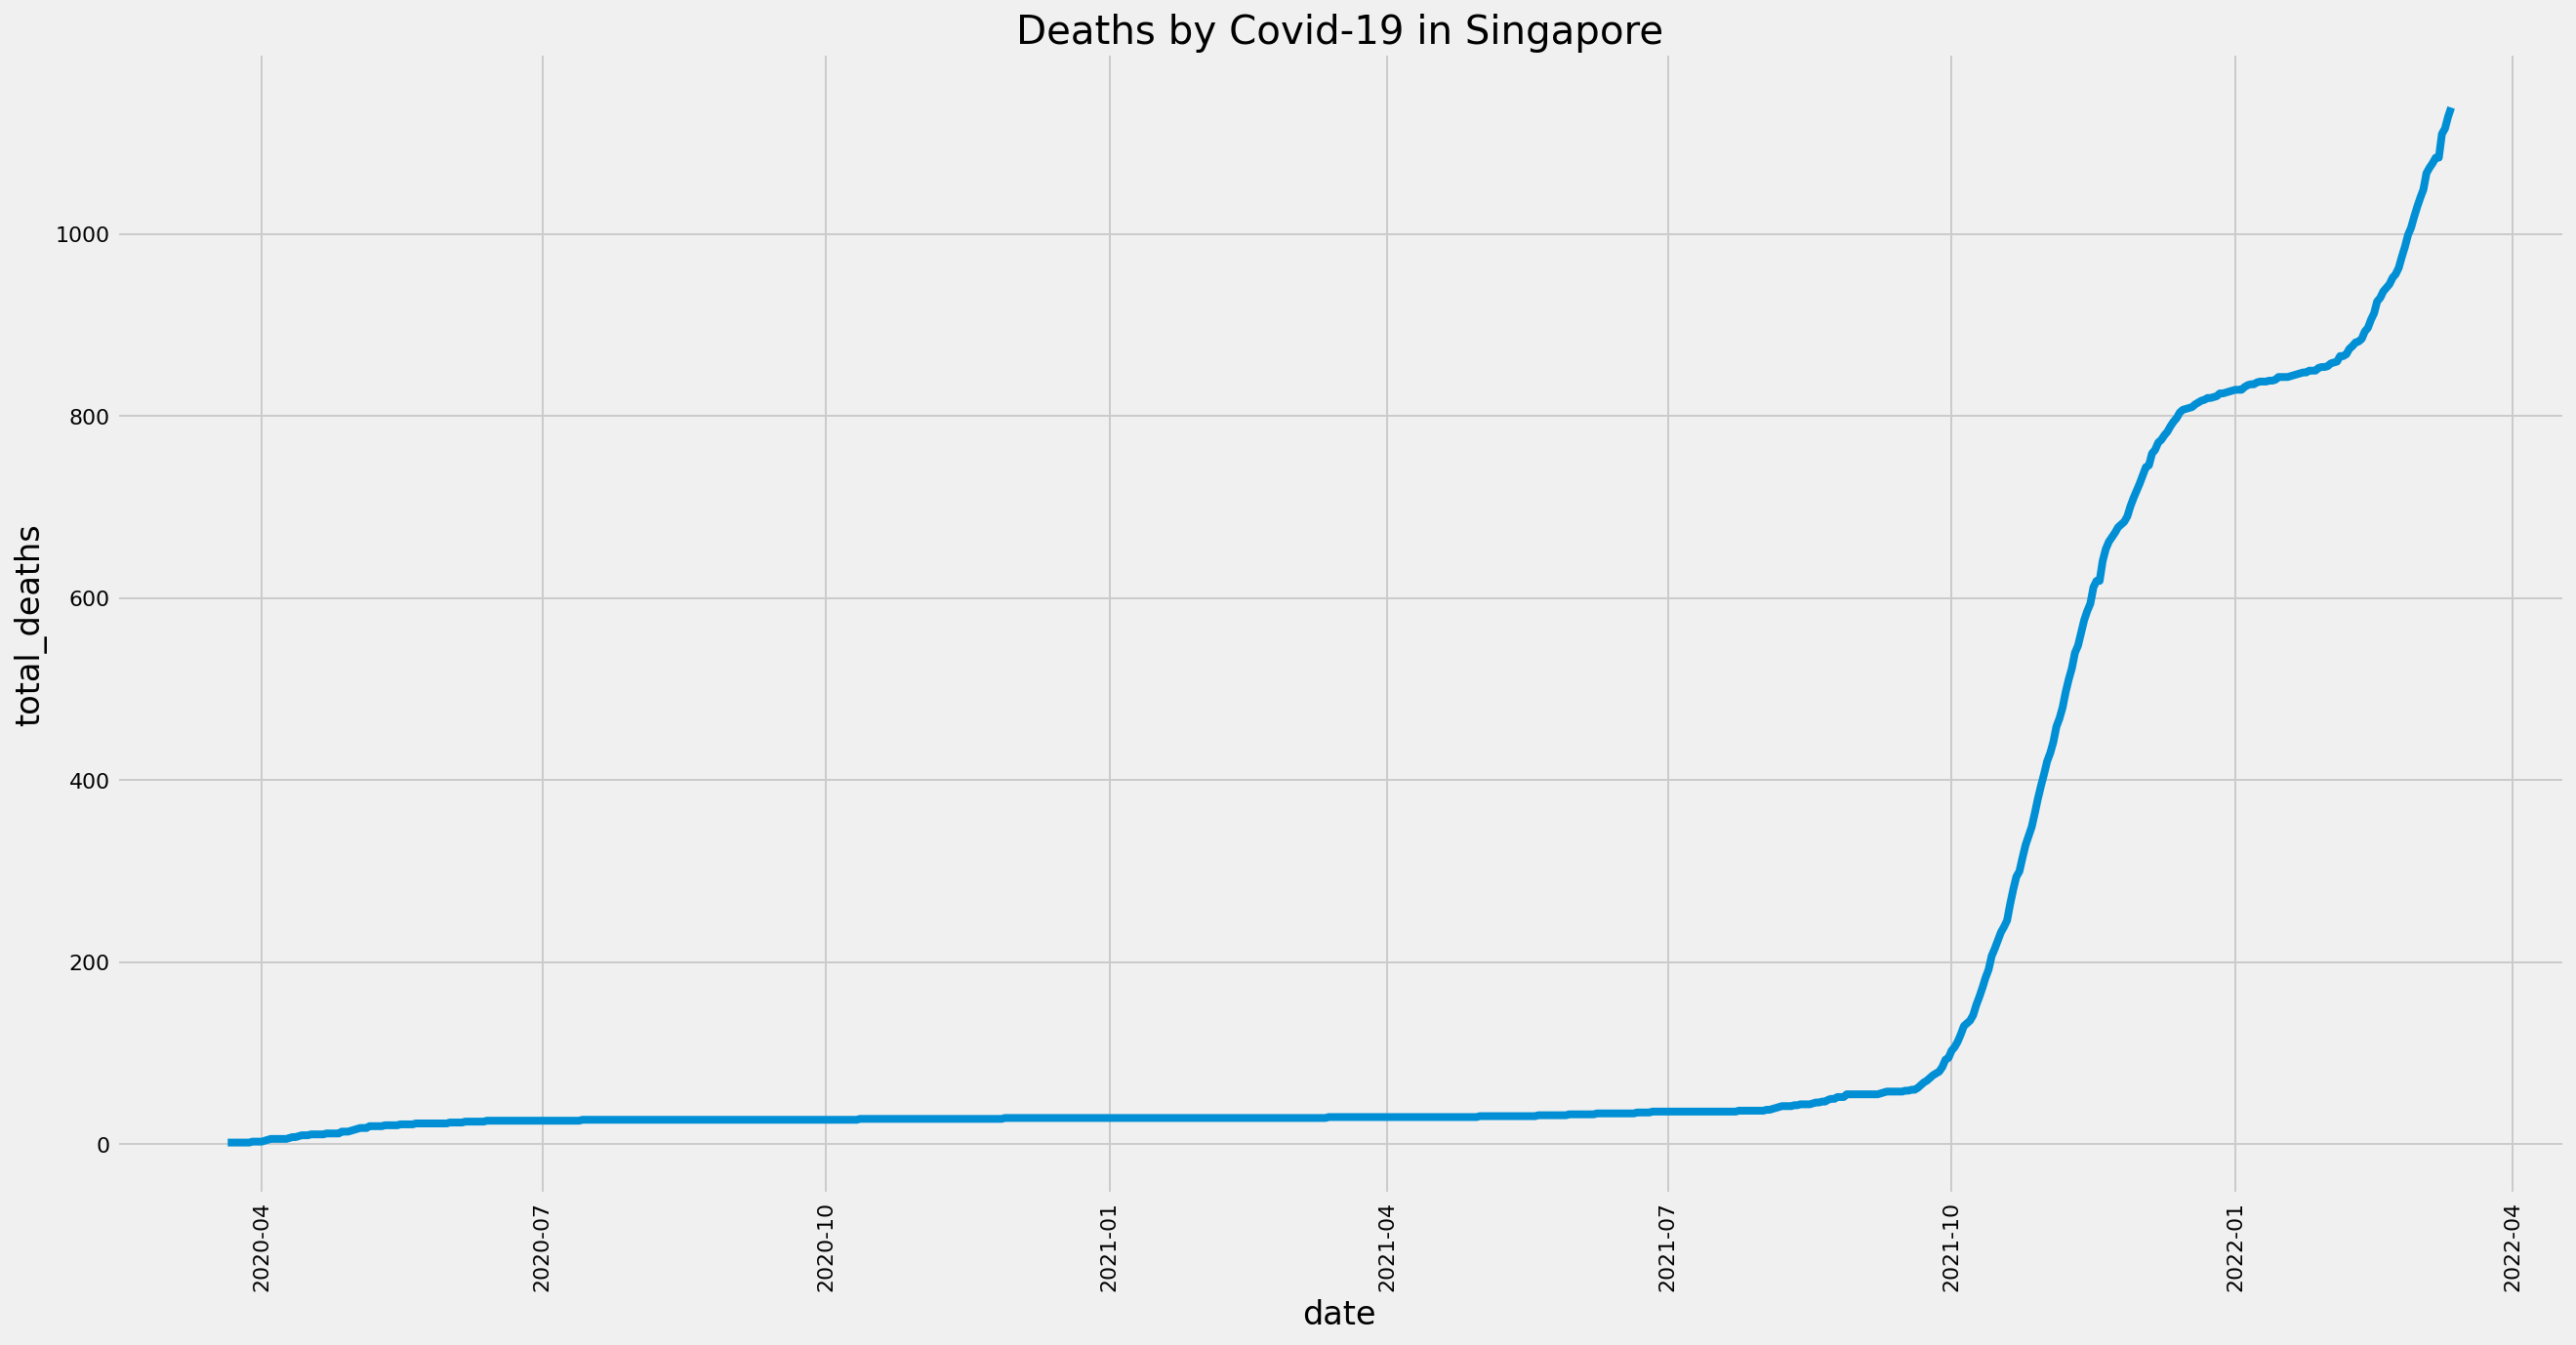

In [461]:
plt.figure(figsize=(20,10))
sns.lineplot(data=df_death_percent, x='date', y='total_deaths')
plt.title('Deaths by Covid-19 in Singapore')
plt.xticks(rotation=90)
plt.show()

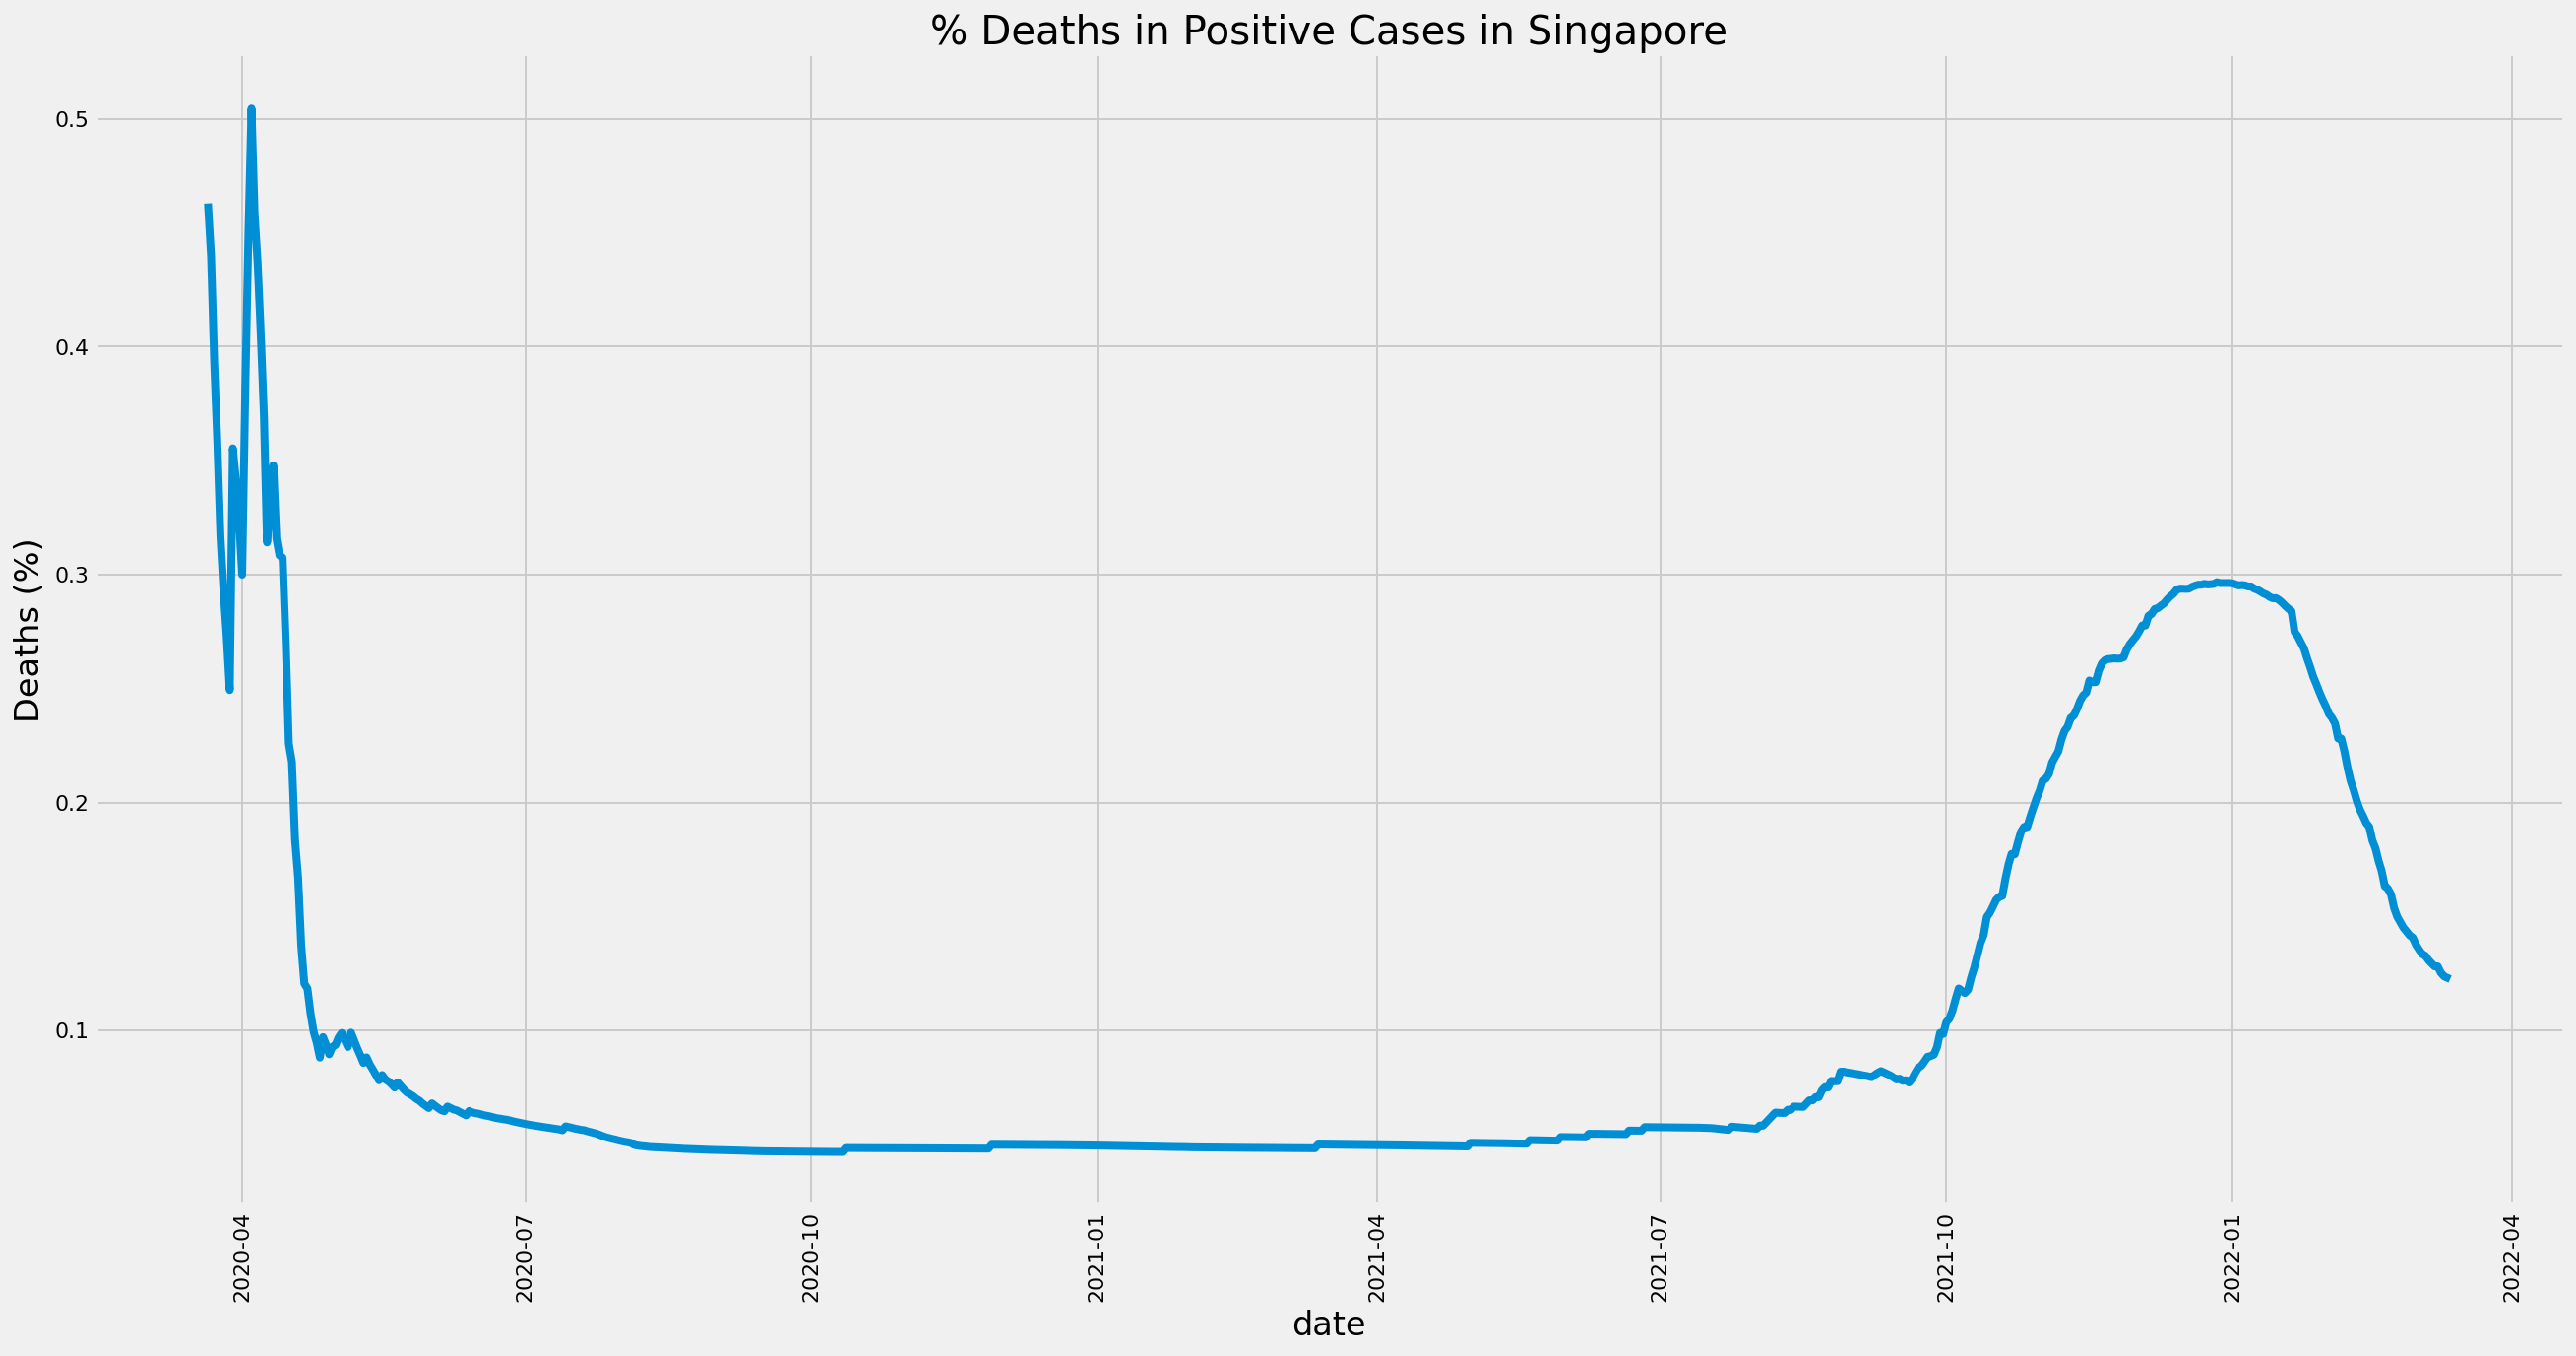

In [462]:
plt.figure(figsize=(20,10))
sns.lineplot(data=df_death_percent, x='date', y='DeathPercentage')
plt.title('% Deaths in Positive Cases in Singapore')
plt.ylabel('Deaths (%)')
plt.xticks(rotation=90)
plt.show()

### Percentage of Postive Cases Over Time
Likelihood to contract COVID-19 over time

In [463]:
casesquery = '''

SELECT location, date, population, total_cases, (total_cases/population)*100 as CasesPercentage
FROM PortfolioProject..COVIDDeaths$
Where location = 'Singapore'
Order By 1, 2

'''

df_casesquery = pd.read_sql_query(casesquery,engine)
df_casesquery = df_casesquery.fillna(value=np.nan)
df_casesquery.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   location         780 non-null    object 
 1   date             780 non-null    object 
 2   population       780 non-null    float64
 3   total_cases      780 non-null    float64
 4   CasesPercentage  780 non-null    float64
dtypes: float64(3), object(2)
memory usage: 30.6+ KB


In [464]:
df_casesquery['date'] = pd.to_datetime(df_casesquery['date'])

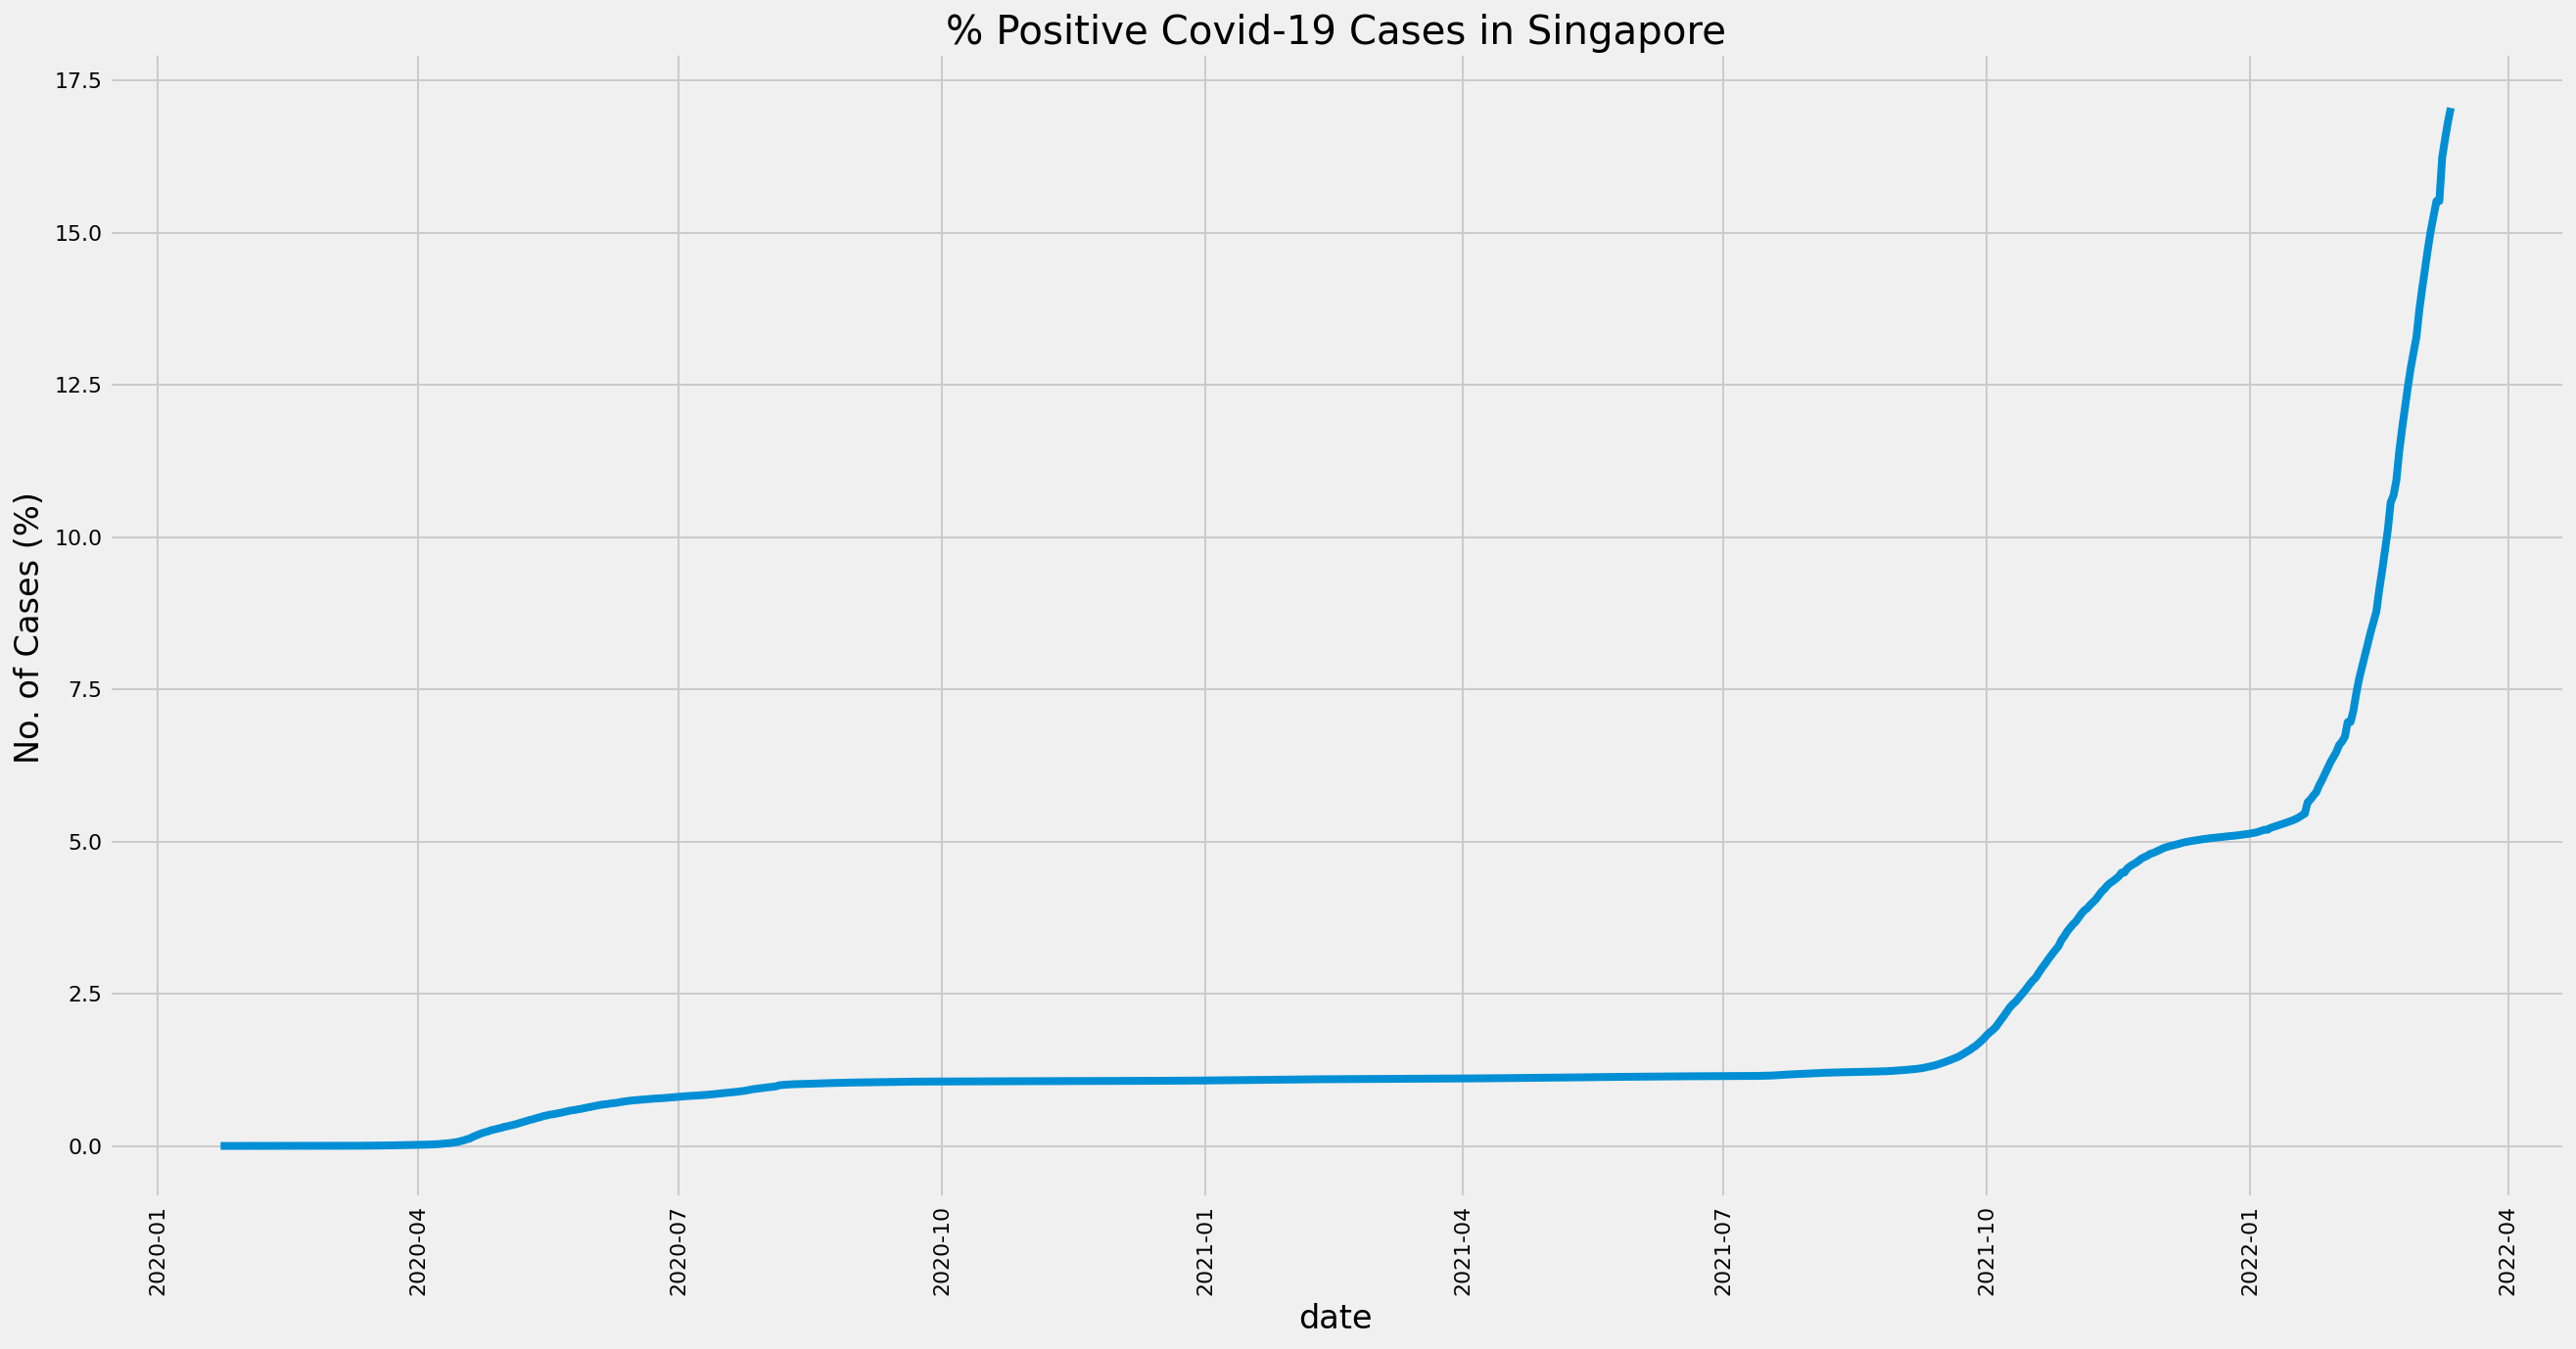

In [465]:
plt.figure(figsize=(20,10))
sns.lineplot(data=df_casesquery, x='date', y='CasesPercentage')
plt.title('% Positive Covid-19 Cases in Singapore')
plt.ylabel('No. of Cases (%)')
plt.xticks(rotation=90)
plt.show()